# Homework 9

## Assignment 2 - Census geospatial analysis.

### Completed by #JKtours (jlk635)

In [1]:
# my usual imports and setups
import pylab as pl
import pandas as pd
import numpy as np
#imports downloader

import scipy.stats
from geopy.geocoders import Nominatim
import geopandas as gp
from __future__ import print_function, division

import urllib.request
import io

import statsmodels.api as sm
import statsmodels.formula.api as smf


from matplotlib import pyplot as plt
from fiona.crs import from_epsg

import choroplethNYC as cp

%pylab inline
import json
import os, shutil
import sys
import requests
import shapely

Populating the interactive namespace from numpy and matplotlib


## GOAL: is to assess whether the location of the [linkNYC](https://www.link.nyc/) access points is optimal to guarantee a more "democratic" access to the internet.


# I always thought PUMAs were the Argentinian Rugby team, judging by the following... maybe not just

# 1. PUMA : Public Use Microdata Area
Census geographies that are not specific political entities (i.e. states, counties etc) are designed for homogeneity so that aggregating the data over the whole area will leat to an estimat (mean or median for example) with minimal variance. Among these geographies are the _census tracts_, _census blocks_, and _Public Use Microdata Areas (PUMAs)_. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state. 

## 1.1 download the NYC  Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas

https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data


# Data load 

In [2]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
filename = "PUMA.zip"

urllib.request.urlretrieve(url, filename)

os.system("mv " + filename + " " + os.getenv("PUIDATA")) #moves file to PUIDATA directory


0

In [3]:
#
os.system("unzip " + os.getenv("PUIDATA") + "/" + filename + " -d " + os.getenv("PUIDATA") + "/pumaData")



0

# Create geodataframe from shapefile

In [4]:
files = os.listdir(os.getenv("PUIDATA") + "/pumaData")
shpfile = [x for x in files if 'shp' in x]

In [5]:
shpfile[0]

'geo_export_2693dd80-0a43-4046-93c0-7959d33a8cf4.shp'

In [6]:
pumashp = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/pumaData" + "/" + shpfile[0])

In [7]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [8]:
pumashp.crs

{'init': 'epsg:4326'}

## 1.2  plot the PUMA NYC regions

In loading packages earlier, I imported the choropleth package.

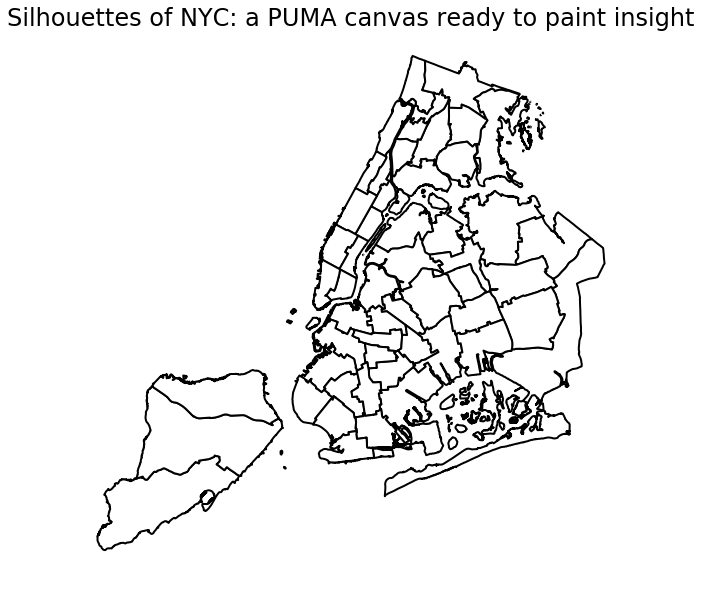

In [9]:
cp.choroplethNYC(pumashp, column=None, color="white", edgecolor="black", lw=2);
pl.title("Silhouettes of NYC: a PUMA canvas ready to paint insight", fontsize = 24);

**Figure 1:** Plot of Public Use Microdata Area (PUMA) geometries for NYC. We can see the five (5) boroughs represented (although Borough borders not clearly marked). We'll use this choropleth as a base to plot other variables and hopefully craft relevant insights

# 2. American Fact Finder data on percentage of houses with broadband internet access

Obtained data on broadband access (percentage of households with broadband access) at the PUMA (Public Use Microdata Area) geographical area level. 

Reviewing the Census and American Community Survey data. 

I used the API (and got myself an API key).


## 2.1 Get data with American Fact Finder (AFF) API: 



In [10]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

Reading in variables from the API

In [11]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [12]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())


In [13]:
affkeys

array(['C27014_019E', 'C08406_032EA', 'B06009_023M', ..., 'B13002_007EA',
       'B17001I_040EA', 'B19001G_001MA'], 
      dtype='<U15')

We need two features: **total number of households**, and **number of households with broadband access**

Thank you for providing the following code which helps to find the relevant fields required.

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_008MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_004EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_

The keyword for the *number of households* is **'B28002_001E'**

In [15]:
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

The keyword for the *number of households with broadband access* is **'B28002_004E'**

In [16]:
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

## Extracting relevant data with the ACS API

Now that you have the variable names use them to extract the relevant data with the ACS API. 

The API url is as follows:

root: https://api.census.gov/data/2016/acs/acs1

action: get=\[variable Name\],NAME

geometry: for=\[geometry\]:\[desired geometry values\]in=\[larger geometry\]:\[desired larger geometry values\]

API key: key:\[api key\]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":\*" means all PUMAS

state:36 is New York State

In [17]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaBB.drop( ['Unnamed: 4'], axis=1, inplace=True)  

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area
0,32607,"St. Lawrence County PUMA, New York",36,100
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,41210,"Warren & Washington Counties PUMA, New York",36,300
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [18]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.drop( ['Unnamed: 4'], axis=1, inplace=True)

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area
0,40479,"St. Lawrence County PUMA, New York",36,100
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,51614,"Warren & Washington Counties PUMA, New York",36,300
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [19]:
pumaPP.shape, pumaBB.shape

((145, 4), (145, 4))

## 2.2 generate a feature for the percentage of households with broadband access

In [20]:
pumaBB = pd.merge(pumaBB, pumaPP, on=['NAME','state','public use microdata area'], how='inner')


In [21]:
#Rename columns
pumaBB.rename(columns = {'B28002_004E':"CountOfBB", 'B28002_001E':"CountOfHH"}, inplace = True)


In [22]:
pumaBB['pcBB'] = pumaBB['CountOfBB'] / pumaBB['CountOfHH']*100

In [23]:
pumaBB.head()

,CountOfBB,NAME,state,public use microdata area,CountOfHH,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above



The table 'GCT280' is manually downloaded from the GCT Geographic Comparison Tables for PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION from: https://factfinder.census.gov/

The geography required in PUMA level granularity.

We moved the file to the PUIdata directory, unzipped and loaded into pandas.

The code following reads in the CSV, which had previously been unzipped from the file


In [24]:
filename1 = 'ACS_16_1YR_GCT2801.ST50.zip'
#
os.system("unzip " + os.getenv("PUIDATA") + "/" + filename1 + " -d " + os.getenv("PUIDATA") + "/affData")

256

In [25]:
bbpc = pd.read_csv(os.getenv("PUIDATA")+ "/affData" + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["Target Geo Id2", "Percent", "Margin of Error"], header=1)

bbpc["gid"] = bbpc["Target Geo Id2"] - 3600000

bbpc.head()

,Target Geo Id2,Percent,Margin of Error,gid
0,1,74.7,0.5,-3599999
1,100100,70.9,2.5,-3499900
2,100200,80.5,2.7,-3499800
3,100301,87.0,2.8,-3499699
4,100302,81.9,2.9,-3499698


In [26]:
bbpc.shape

(2430, 4)

### Good hints - thank you

notice 2 things:
    - that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
    - that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.
    
In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id 

## Performed check that the percentage of households with broadband generated from API data and the one read in from the table downloaded manually are the same

In [27]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["gid","public use microdata area","pcBB", "Percent"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["Percent"].astype(float))

diff_.describe()

,gid,public use microdata area,pcBB,Percent,diff
count,145.000000,145.000000,145.000000,145.000000,145.000000
mean,2826.827586,2826.827586,81.845478,81.843448,0.026217
std,1210.054822,1210.054822,7.063369,7.065358,0.014480
min,100.000000,100.000000,54.932945,54.900000,0.000178
25%,1900.000000,1900.000000,77.770257,77.800000,0.012252
50%,3208.000000,3208.000000,82.826141,82.800000,0.027230
75%,3809.000000,3809.000000,87.305077,87.300000,0.039090
max,4114.000000,4114.000000,93.404143,93.400000,0.049872


The maximum difference is very small - less than 0.05%

# 3 Plot a choropleth of NYC broadband access 
## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

## THIS IS RETURNING AN ERROR FOR SOME REASON BUT IT'S COMPUTING THE DATASET, JUST KEEP RUNNING THE NOTEBOOK

In [28]:
#choropleth of the percentage of internet axcess
pumashp["puma"] = pd.to_numeric(pumashp["puma"])
pumashp = pumashp.merge(pumaBB, right_on="public use microdata area", 
                     left_on="puma")[["puma","public use microdata area",
                                      "shape_leng","shape_area","geometry","pcBB"]]

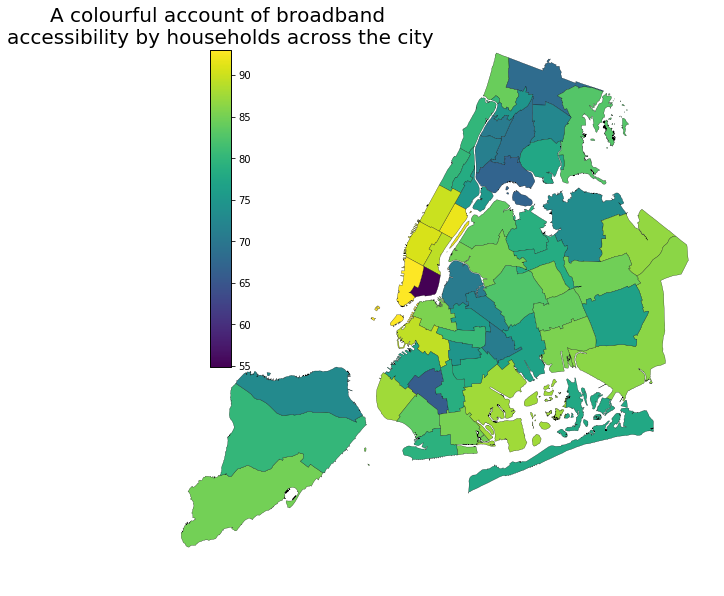

In [29]:
cp.choroplethNYC(pumashp, column = "pcBB", edgecolor='black', lw=.25);
pl.title("A colourful account of broadband \naccessibility by households across the city", fontsize = 20);

**Figure 2:** Plot of percentage of households with Broadband Access by Public Use Microdata Area (PUMA) for NYC. 

Comparing across the five (5) boroughs, we see proportion of households with access is higher across Manhattan upto Mid-town, and lower extending into the Bronx. There looks to be an outlier with very low access in the southern eastern most PUMA with coverage around 55%. 

There is a good proportion of access across both Queens and Brooklyn ranging from 65-90% 

Access on Staten Island is fairly consistent with 70-80% of households enabled.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

Acquired the linkNYC locations and prepared them into a dataframe
read it in from the HW9_fb55 folder in :
https://github.com/fedhere/PUI2017_fb55


In [30]:
linkLink = 'https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv'

linkNYC = pd.read_csv(linkLink )
linkNYC.drop(['Unnamed: 0'], axis=1, inplace=True)

In [31]:
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [32]:
linkNYC.shape

(1414, 4)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame _linkNYC_ and set native coordinates  frame to lat/lon as you did in the lab
*linkNYC.crs = 4326*

In [33]:
linkNYC.dtypes

link_site      object
longitude     float64
date_link_     object
latitude      float64
dtype: object

In [34]:

# combine lat and lon to one column
linkNYC['lonlat'] = list(zip(linkNYC.longitude,linkNYC.latitude))


In [35]:
# Create Point Geometry for based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [36]:
crs = {'init': 'epsg:4326'}
gdfLinkNYC = gp.GeoDataFrame(linkNYC, crs=crs)
gdfLinkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [37]:
#pumashp = pumashp.to_crs(epsg=2263)
#gdfLinkNYC = gdfLinkNYC.to_crs(epsg=2263)

# Plotted the location of the linkNYC stations on top of a choropleth of broadband access percentage in *5 equal intervals*

Added location of the linkNYC stations also

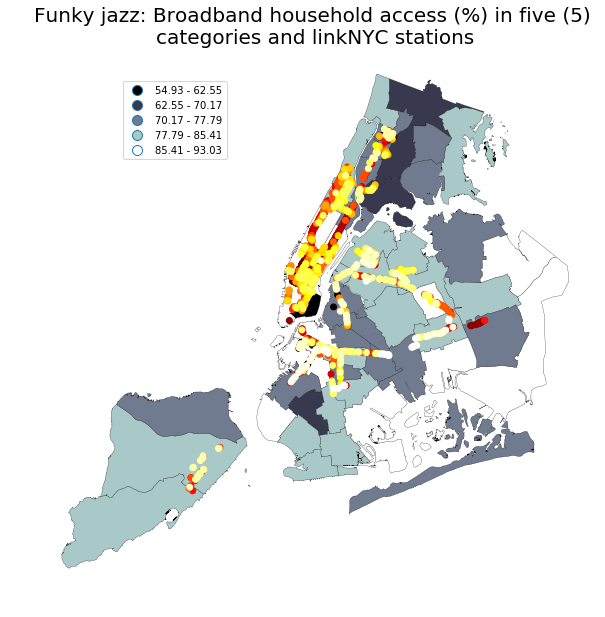

In [38]:
item, fig, axes = cp.choroplethNYC(pumashp, column = "pcBB", cmap='bone', edgecolor='black', lw=.25, 
                          scheme='equal_interval',k=5);
cp.choroplethNYC(gdfLinkNYC, ax=fig, cmap="hot");
pl.title("Funky jazz: Broadband household access (%) in five (5) \ncategories and linkNYC stations", fontsize = 20);

**Figure 3:** Plot of five (5) equal bands of percentage of households with Broadband Access by Public Use Microdata Area (PUMA) for NYC. Overlay linkNYC stations, public broadband access points.

There appears to be some relationship between proportion of households with access to broadband, and number of link stations (mainly concentrated on Manhattan and along transport corridors in Brooklyn, Queens and parts of the Bronx. 

There is a large opportunity in the Eastern parts of the Bronx to provide linkNYC stations to parts of the city which have some of the lowest access to broadband per household in the whole city.


# 5 Find the number of linkNYC locations per person by PUMA

## 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF

**Hint:** The ACS population by  variable is B00001_001E, and of course your geometry is PUMA, _public%20use%20microdata%20area:*_, as before

In [39]:
keyPOP = 'B00001_001E'
aff1y['variables'][keyPOP]

{'attributes': 'B00001_001EA',
 'concept': 'UNWEIGHTED SAMPLE COUNT OF THE POPULATION',
 'group': 'B00001',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [40]:
# getting population by geometry
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyPOP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPOP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPOP.drop( ['Unnamed: 4'], axis=1, inplace=True)  

#Rename columns
pumaPOP.rename(columns = {'B00001_001E':"CountOfPOP"}, inplace = True)

pumaPOP.head()

,CountOfPOP,NAME,state,public use microdata area
0,3075,"St. Lawrence County PUMA, New York",36,100
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200
2,2736,"Warren & Washington Counties PUMA, New York",36,300
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402


In [41]:
pumashp.columns

Index(['puma', 'public use microdata area', 'shape_leng', 'shape_area',
       'geometry', 'pcBB'],
      dtype='object')

In [42]:
#pumashp.merge()
pumashp = pumashp.merge(pumaPOP, right_on="public use microdata area", 
                     left_on="puma")[['puma', 
                                      'shape_leng', 'shape_area',
                                       'geometry', 'CountOfPOP', 'pcBB']]




In [43]:
pumashp.head()

,puma,shape_leng,shape_area,geometry,CountOfPOP,pcBB
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,84.275820
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...,1959,68.310015
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,82.826141
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,72.553737
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...,2011,69.425612


## 5.2 Find the number of station per 100 people per PUMA

I used sjoin to do this. 

I was also very careful to change to the relevant geometries before commisioning the spatial join.

Convert coordinates for pumashp and linkNYC

In [44]:
pumashp['geometry'] = pumashp['geometry'].to_crs(epsg=2263)
gdfLinkNYC['geometry'] = gdfLinkNYC['geometry'].to_crs(epsg=2263)

Create a geodataframe with a spatial join and use groupby to count the number of linkNYC in each PUMA

In [45]:

linkpp = gp.sjoin(pumashp, gdfLinkNYC).groupby(by="puma", as_index=False).count()
linkpp.drop( ['shape_leng', 'shape_area', 'geometry', 'CountOfPOP', 'pcBB',
       'index_right', 'longitude', 'date_link_', 'latitude',
       'lonlat'] , axis=1, inplace=True) 
linkpp.rename(columns = {'link_site':'linkSiteCount'}, inplace = True)
linkpp.head()

,puma,linkSiteCount
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [46]:
pumashp.shape



(55, 6)

In [47]:
#choropleth of the percentage of internet axcess

pumashplc = pumashp.merge(linkpp, right_on="puma", left_on="puma",how='left')
pumashplc['linkSiteCount'] = pumashplc['linkSiteCount'].fillna(value=0)
pumashplc["linkNYCp100p"] = pumashplc['linkSiteCount'] / ( pumashplc['CountOfPOP'] / 100)
pumashplc.head()

,puma,shape_leng,shape_area,geometry,CountOfPOP,pcBB,linkSiteCount,linkNYCp100p
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",1517,84.275820,1.0,0.065920
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",1959,68.310015,0.0,0.000000
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,1305,82.826141,0.0,0.000000
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",1882,72.553737,0.0,0.000000
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",2011,69.425612,1.0,0.049727


Finally merge back into the pumashp. I used a left join and checked I had the same number of PUMI (is that the official plural term for PUMA) in my pumashp file before and after the join (this doesn't neccesarily guarantee I performed the join correctly, but it's a helpful check).

In [48]:
#Good descriptive stats on linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

count    55.000000
mean      1.565892
std       2.933074
min       0.000000
25%       0.000000
50%       0.538358
75%       1.646966
max      15.141540
Name: linkNYCp100p, dtype: float64

# Plot the linkNYC locations on top of a choropleth of number of stations per 100 people  in 10 equal intervals


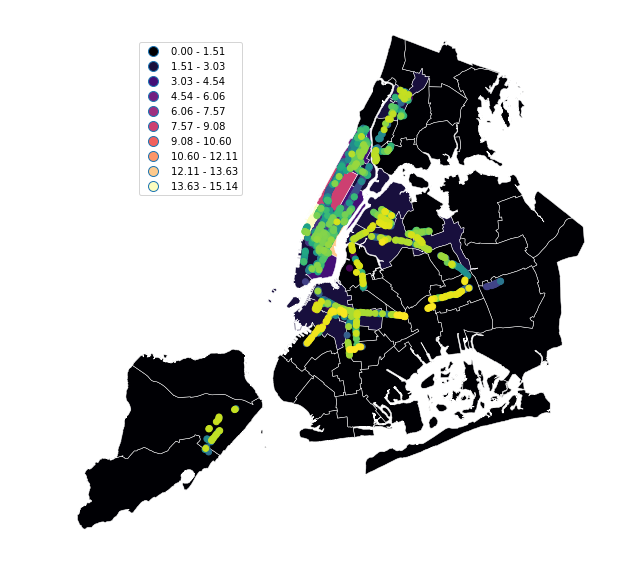

In [49]:
item, fig, axes = cp.choroplethNYC(pumashplc, column = "linkNYCp100p", cmap='magma', edgecolor='white', lw=.5, 
                          scheme='equal_interval',k=10);
cp.choroplethNYC(gdfLinkNYC, ax=fig, cmap="viridis");

**Figure 4:** Plot of ten (10) equal bands of number of linkNYC stations per 100 people across each Public Use Microdata Area (PUMA) for NYC. We plotted the linkNYC stations also on top, showing public broadband access points.

# Extra credit 1: 
How would you enhance the visibility of this map? you are working with numbers that are mostly very low, and reside near each other, and them have a few much higher value points. Notice that here the high values are interesting though and should not be thrown away!

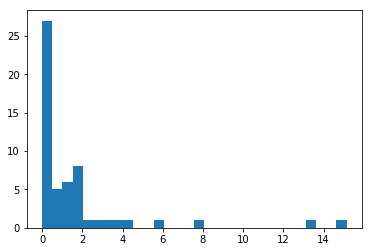

In [50]:
pl.hist(pumashplc["linkNYCp100p"], bins=30);

In [51]:
pumashplcCut = pumashplc[(pumashplc.linkNYCp100p == 0)]
pumashplcCut.head()

,puma,shape_leng,shape_area,geometry,CountOfPOP,pcBB,linkSiteCount,linkNYCp100p
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",1959,68.310015,0.0,0.0
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,1305,82.826141,0.0,0.0
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",1882,72.553737,0.0,0.0
8,3709,73289.990781,1.241170e+08,"(POLYGON ((1029456.00079346 237188.9177855959,...",2193,77.645705,0.0,0.0
22,3903,158136.516459,3.761981e+08,(POLYGON ((939997.0947875979 173013.5794066831...,2680,72.977683,0.0,0.0


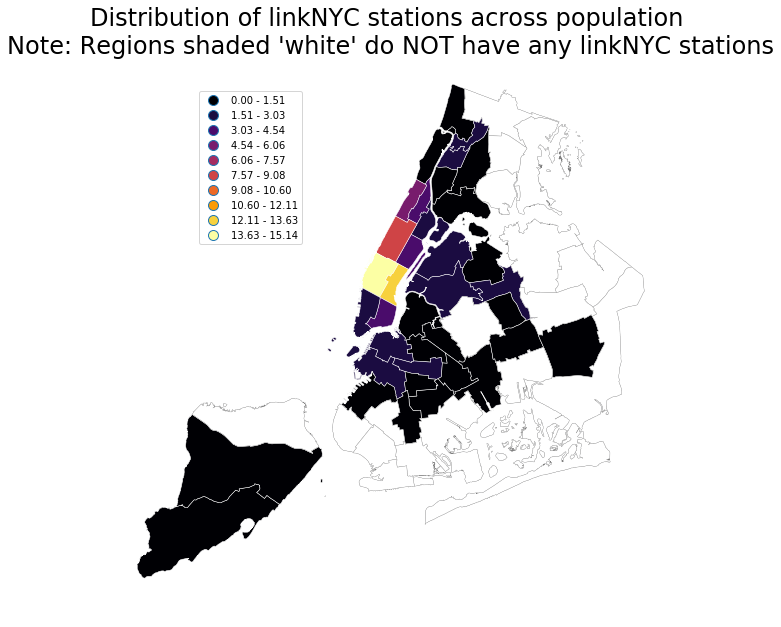

In [52]:
item, fig, axes = cp.choroplethNYC(pumashplc, column = "linkNYCp100p", cmap='inferno', edgecolor='white', lw=.5, 
                          scheme='equal_interval',k=10);
cp.choroplethNYC(pumashplcCut, ax=fig, color="white", edgecolor='gray', lw=.25);
plt.title("Distribution of linkNYC stations across population \n"+ 
          "Note: Regions shaded 'white' do NOT have any linkNYC stations", fontsize = 24);

**Figure 5:** Plot of ten (10) equal bands of number of linkNYC stations per 100 people across each Public Use Microdata Area (PUMA) for NYC. The regions indicated do not have any linkNYC stations across the whole PUMA (i.e. they're not served parts ofthe community). The regions plotted in black indicate the underserved parts of the community.

### Lots of people plotted the quartiles / quintiles for this. I stuck with the original approach in 5.2. What I found interesting was it was difficult to distinguish between the 'low' (close to zero, but not zero) proportion of linkNYC stations to people vs. the 'no' linkNYC stations to people, because they are coloured dark but actually represent quite different data points. 

I changed all the PUMA's with no linkNYC to **white**. They can be classified as **'not served'**. I'm reluctant to classify them as underserved. There's obviously a reason those PUMAs haven't been allocated any linkNYC stations. Maybe it's related to the types of transport corridors people in those regions use e.g. they might be in cars more often and not need the charging requirements provided by the linkNYC stations (we need to consider this may not just be about broadband). 

The PUMAs shown in **black** now, represent the **low coverage of linkNYC stations per 100 people**, i.e. they have at least one (1) linkNYC station, but not anywhere enough to service the needs of the population of that PUMA in an equitable fashion. Either you can choose to make the distribution of linkNYC stations more equitable, or live with the fact that you're underservicing (and indeed **NOT servicing**) parts of the population, predominantly outside on Manhattan.



## Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. You can follow what you did in the lab, but you need to create a metric based on the data you have tha measures the impact of linkNYC


In [53]:
#new imports

import pysal as ps
from matplotlib import colors

In [54]:
# new dataframe for lag analysis

dfLagAnalysis = pumashplc

In [55]:
dfLagAnalysis.head()

,puma,shape_leng,shape_area,geometry,CountOfPOP,pcBB,linkSiteCount,linkNYCp100p
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",1517,84.275820,1.0,0.065920
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",1959,68.310015,0.0,0.000000
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,1305,82.826141,0.0,0.000000
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",1882,72.553737,0.0,0.000000
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",2011,69.425612,1.0,0.049727


We formulate two measures to undertake the lag analysis. One relates to number of people with no broadband at home. The other standardised the number of people without broadband at home by dividing by the public access linkNYC stations within the area.

In [56]:
#people with no broadband access at home
noBroadband = ((100 - dfLagAnalysis.pcBB)*dfLagAnalysis.CountOfPOP*0.01)

#standardised view of people with no broadband access at home divided by count of LinkNYC stations nearby
noBroadbandStdLinkNYC = ((100-dfLagAnalysis.pcBB)*dfLagAnalysis.CountOfPOP*0.01/dfLagAnalysis.linkSiteCount) 

dfLagAnalysis.accessibility = noBroadband/noBroadbandStdLinkNYC

In [57]:
#default parameters of normalization (scale from 0 to 1)
max=5
min=0

def minmaxStd(col):
    '''
    This function creates a Min Max Scaling of a column in a dataframe
    The input should be the colum to normalize'''
    col_std = (col - col.min(axis=0)) / (col.max(axis=0) - col.min(axis=0))
    col_scaled = col_std * (max - min) + min
    return col_scaled

In [58]:
#Normalizing accesibility
dfLagAnalysis.accessibility = minmaxStd(dfLagAnalysis.accessibility)

In [59]:
pathName = os.getenv("PUIDATA") + "/pumaData" + "/" + shpfile[0]

dfLagAnalysis.to_file(pathName)

In [60]:
#descriptive statistics on accesibility
dfLagAnalysis.accessibility.describe()

count    55.000000
mean      0.558893
std       0.914333
min       0.000000
25%       0.000000
50%       0.260870
75%       0.663043
max       5.000000
dtype: float64

In [61]:
#using queens weights
qW_CT=ps.queen_from_shapefile(pathName)

In [62]:
#Using the queens weights based on the shape file to assign the lag based on the accesibility metric
BBaccessibility = dfLagAnalysis.accessibility
BBaccessibilityLag=ps.lag_spatial(qW_CT, BBaccessibility)

In [63]:
#Creating accessibility quintiles
BBaccessibilityLagLagQ5 = ps.Quantiles(BBaccessibilityLag, k=5)
BBaccessibilityLagLagQ5

               Quantiles                
 
Lower            Upper             Count
         x[i] <=  0.426               11
 0.426 < x[i] <=  1.043               12
 1.043 < x[i] <=  1.726               10
 1.726 < x[i] <=  4.130               11
 4.130 < x[i] <= 11.913               11

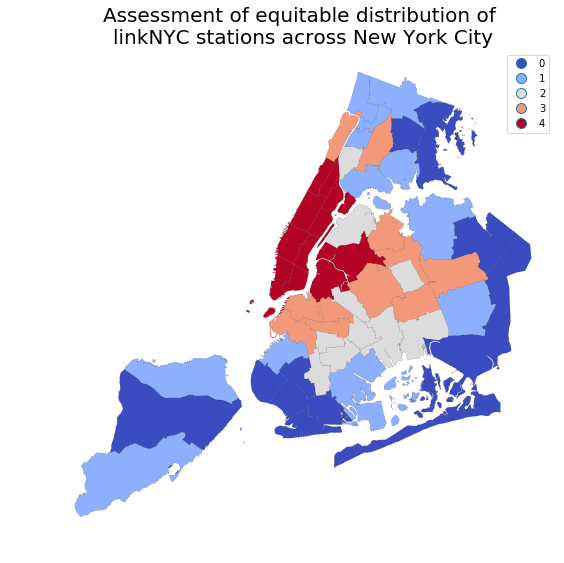

In [64]:
#Plot the lag
f, ax = plt.subplots(figsize=(9, 9))
dfLagAnalysis.assign(cl=BBaccessibilityLagLagQ5.yb).plot(column='cl', categorical=True, 
        cmap='coolwarm', linewidth=0.1, ax=ax, 
       edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Assessment of equitable distribution of \nlinkNYC stations across New York City", fontsize = 20);

**Figure 6:** Plot of spatial lags showing whether distribution of linkNYC stations is 'equitable' across New York City. Broadly, we want to assess whether the linkNYC stations are located in areas where access to broadband in households is lower. Dark red shows high accessibility, Dark Blue shows low accesibility to internet (be it public (linkNYC), or household access).

The colours in this map show dark red areas have high proportion of broadband access at home, and also a high number of linkNYC stations in the areas. Dark blue show areas where there are low levels of broadband access at home, and service by linkNYC stations is also low. 

The light red, light blue, and grey sections are a combination of either high accessibility of broadband at home paired with limited linkNYC stations in the neighbourhood; or the opposite.. low accesibility to broadband at home, paired with a higher number of linkNYC public broadband stations in the neighbourhood.



## Pretty insightful - THANK YOU.